In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation
%matplotlib ipympl
import numpy as np
import pandas as pd
import pims
import networkx as nx

from scipy.spatial import KDTree, cKDTree, Voronoi, voronoi_plot_2d, ConvexHull
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import time
import joblib
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentzian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities

from networkx.algorithms.community import greedy_modularity_communities
import networkx as nx 
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import graph_tool.all as gt

show_verb = False
run_windowed_analysis = True
plot_verb = True
animated_plot_verb = True
save_verb = True
run_analysis_verb = True

msd_run = False
speed_run = False
turn_run = False
autocorr_run = True
rdf_run = False


(ipykernel_launcher.py:37094): Gtk-WARNING **: 21:10:37.820: Locale not supported by C library.
	Using the fallback 'C' locale.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
def compute_eccentricity(points):
    centroid = np.mean(points, axis=0)
    distances = np.linalg.norm(points - centroid, axis=1)
    eccentricity = np.std(distances) / np.mean(distances)
    return eccentricity

def motif_search(mofitList, sizeList, g):
    counts = np.zeros(len(mofitList), dtype=int)
    for i, motif in enumerate(mofitList):
        _, temp = gt.motifs(g, sizeList[i], motif_list = [motif])
        counts[i] = temp[0]
    return counts
    
def get_velocities(trajList):
    v = np.zeros((len(trajList), 2, len(trajList[0])), dtype=np.float64)
    for i in range(len(trajList)):
        v[i] = np.array(trajList[i].v).T
    return v

# Power Law fit
def powerLaw(x, a, k):
    return a*x**k

def powerLawFit(f, x, nDrops, yerr):
    if nDrops == 1:
        ret = np.zeros((2, 2))
        ret[0], pcov = curve_fit(powerLaw, x, f, p0 = [1., 1.])
        ret[1] = np.sqrt(np.diag(pcov))
        fit = ret[0, 0] * x**ret[0, 1]
    else:
        fit = np.zeros((nDrops, f.shape[0])) # np.zeros(f.shape).T
        ret = np.zeros((nDrops, 2, 2))
        for i in range(nDrops):
            if yerr is None:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.])
            else:
                ret[i, 0], pcov = curve_fit(powerLaw, x, f[i], p0 = [1., 1.], sigma = yerr)
            ret[i, 1] = np.sqrt(np.diag(pcov))
            fit[i] = ret[i, 0, 0] * x**ret[i, 0, 1]
    return fit, ret 


def get_imsd(trajs, pxDimension, fps, maxLagtime, nDrops):
    imsd = tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
    # fit the diffusive region of the MSD --> 1s onwards
    fit, pw_exp = powerLawFit(imsd[1:], imsd[1:].index, nDrops, None)
    return imsd, fit, pw_exp


def get_emsd(imsd, x, fps, red_mask, nDrops):
    MSD = np.array(imsd)
    MSD_b = [MSD[:, ~red_mask].mean(axis = 1),
                MSD[:, ~red_mask].std(axis = 1)]
    MSD_r = [MSD[:, red_mask].mean(axis = 1),
                MSD[:, red_mask].std(axis = 1)]
    # fit the diffusive region of the MSD
    fit_b, pw_exp_b = powerLawFit(MSD_b[0][fps-1:], x, 1, MSD_b[1][fps-1:])
    fit_r, pw_exp_r = powerLawFit(MSD_r[0][fps-1:], x, 1, MSD_r[1][fps-1:])
    results = {"fit_b": fit_b, "pw_exp_b": pw_exp_b, "fit_r": fit_r, "pw_exp_r": pw_exp_r}
    return MSD_b, MSD_r, results


def get_imsd_windowed(nSteps, startFrames, endFrames, trajs, pxDimension, fps, maxLagtime, nDrops):
    MSD_wind = []
    # diffusive region of the MSD
    fit_wind = np.zeros((nSteps, nDrops, maxLagtime - fps+1))
    pw_exp_wind = np.zeros((nSteps, nDrops, 2, 2))
    for i in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[i], endFrames[i])]
        temp, fit_wind[i], pw_exp_wind[i], = get_imsd(trajs_wind, pxDimension, fps, maxLagtime, nDrops)
        MSD_wind.append(temp)
    return MSD_wind, fit_wind, pw_exp_wind


def get_emsd_windowed(imsds, x, fps, red_particle_idx, nSteps, maxLagtime):
    EMSD_wind = np.array(imsds)
    EMSD_wind_b = [EMSD_wind[:, :, ~red_mask].mean(axis = 2), 
                    EMSD_wind[:, :, ~red_mask].std(axis = 2)]
    EMSD_wind_r = [EMSD_wind[:, :, red_mask].mean(axis = 2), 
                    EMSD_wind[:, :, red_mask].std(axis = 2)]

    # diffusive region of the MSD
    fit_wind_b = np.zeros((nSteps, maxLagtime-fps+1))
    pw_exp_wind_b = np.zeros((nSteps, 2, 2))
    fit_wind_r = np.zeros((nSteps, maxLagtime-fps+1))
    pw_exp_wind_r = np.zeros((nSteps, 2, 2))
    
    for i in tqdm(range(nSteps)):
        fit_wind_b[i], pw_exp_wind_b[i] = powerLawFit(EMSD_wind_b[0][i, fps-1:], x, 1, EMSD_wind_b[1][i, fps-1:])
        fit_wind_r[i], pw_exp_wind_r[i] = powerLawFit(EMSD_wind_r[0][i, fps-1:], x, 1, EMSD_wind_r[1][i, fps-1:])
    
    results = {"fit_wind_b":fit_wind_b, "pw_exp_wind_b":pw_exp_wind_b, "fit_wind_r":fit_wind_r,\
                            "pw_exp_wind_r":pw_exp_wind_r}

    return EMSD_wind_b, EMSD_wind_r, results


# get trajectories
def get_trajs(nDrops, red_particle_idx, trajs):
    blueTrajs = []
    redTrajs = []
    for i in range(0, nDrops):
        if i in red_particle_idx:
            p = trajs.loc[trajs.particle == i, ["x","y"]]
            redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
        else:
            p = trajs.loc[trajs.particle == i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
    return blueTrajs, redTrajs


# get speed distributions windowed in time
def speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs, v_step, fps):
    v_blue_wind = []
    v_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTrajs = []
        for i in range(nDrops):
            if i in red_particle_idx:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
            else:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
        v_blue_wind.append(ys.speed_ensemble(blueTrajs, step=v_step))
        v_red_wind.append(ys.speed_ensemble(redTrajs, step=v_step))
    return v_blue_wind, v_red_wind
    

# get turning angles distributions windowed in time
def theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajs, fps):
    theta_blue_wind = []
    theta_red_wind = []
    for k in tqdm(range(nSteps)):
        trajs_wind = trajs.loc[trajs.frame.between(startFrames[k], endFrames[k])]
        blueTrajs = []
        redTrajs = []
        for i in range(nDrops):
            if i in red_particle_idx:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                redTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
            else:
                p = trajs_wind.loc[trajs_wind.particle==i, ["x","y"]]
                blueTrajs.append(Trajectory(p.x, p.y, dt = 1/fps, traj_id=i))
        theta_blue_wind.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
        theta_red_wind.append(ys.turning_angles_ensemble(redTrajs, centered= True))
    return theta_blue_wind, theta_red_wind


# 2D Maxwell-Boltzmann distribution
def MB_2D(v, sigma):
    return v/(sigma**2) * np.exp(-v**2/(2*sigma**2))

# Normal distribution
def normal_distr(x, sigma, mu):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*((x-mu)/sigma)**2)

def lorentzian_distr(x, gamma, x0):
    return 1/np.pi * gamma / ((x-x0)**2 + gamma**2)

# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std

def vacf_windowed(trajectories):        
    vacf_b_wind = []
    vacf_b_std_wind = []
    vacf_r_wind = []
    vacf_r_std_wind = []
    
    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajs)
        temp = ys.vacf(blueTrajs, time_avg = True, lag = maxLagtime)
        vacf_b_wind.append(temp[0])
        vacf_b_std_wind.append(temp[1])
        temp = ys.vacf(redTrajs, time_avg = True, lag = maxLagtime)
        vacf_r_wind.append(temp[0])
        vacf_r_std_wind.append(temp[1])

    vacf_b_wind = pd.DataFrame(vacf_b_wind)
    vacf_b_std_wind = pd.DataFrame(vacf_b_std_wind)
    vacf_r_wind = pd.DataFrame(vacf_r_wind)
    vacf_r_std_wind = pd.DataFrame(vacf_r_std_wind)
    vacf_r_wind.columns = vacf_r_wind.columns.astype(str)
    vacf_b_wind.columns = vacf_b_wind.columns.astype(str)
    vacf_b_std_wind.columns = vacf_b_std_wind.columns.astype(str)
    vacf_r_std_wind.columns = vacf_r_std_wind.columns.astype(str)
    vacf_b_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_b_wind.parquet")
    vacf_b_std_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_b_std_wind.parquet")
    vacf_r_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_r_wind.parquet")
    vacf_r_std_wind.to_parquet(f"./{analysis_data_path}/vacf/vacf_r_std_wind.parquet")
    return vacf_b_wind, vacf_b_std_wind, vacf_r_wind, vacf_r_std_wind
""" 
@joblib.delayed
def rdf_frame(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        n1 = 0
        for j in a:
            n1 += len(j) - 1
        n2 = 0
        for j in b:
            n2 += len(j) - 1
        avg_n[i] = n1/len(a) - n2/len(b)
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf


def get_rdf(run_analysis_verb, nFrames, trajectories, rList, dr, rho):
    
    if run_analysis_verb:
        COORDS = np.array(trajectories.loc[:, ["x","y"]])
        parallel = joblib.Parallel(n_jobs = -2)
        rdf = parallel(
            rdf_frame(frame, COORDS, rList, dr, rho)
            for frame in tqdm(range(nFrames))
        )
        rdf = np.array(rdf)
        rdf_df = pd.DataFrame(rdf)
        # string columns for parquet filetype
        rdf_df.columns = [f"{r}" for r in rList]
        rdf_df.to_parquet(f"./{analysis_data_path}/rdf/rdf.parquet")

    elif not run_analysis_verb :
        try:
            rdf = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf.parquet"))
        except: 
            raise ValueError("rdf data not found. Run analysis verbosely first.")
    else: 
        raise ValueError("run_analysis_verb must be True or False")
    return rdf
"""

@joblib.delayed
def rdf_frame(frame, COORDS_blue, n_blue, COORDS_red, n_red, rList, dr, rho_b, rho_r):
    coords_blue = COORDS_blue[frame*n_blue:(frame+1)*n_blue, :]
    coords_red = COORDS_red[frame*n_red:(frame+1)*n_red, :]
    kd_blue = KDTree(coords_blue)
    kd_red = KDTree(coords_red)

    avg_b = np.zeros(len(rList))
    avg_r = np.zeros(len(rList))
    avg_br = np.zeros(len(rList))
    avg_rb = np.zeros(len(rList))

    for i, r in enumerate(rList):
        # radial distribution function for Blue droplets
        a = kd_blue.query_ball_point(coords_blue, r + dr)
        b = kd_blue.query_ball_point(coords_blue, r)
        avg_b[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for Red droplets
        a = kd_red.query_ball_point(coords_red, r + dr)
        b = kd_red.query_ball_point(coords_red, r)
        avg_r[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for blue-Red droplets
        a = kd_blue.query_ball_point(coords_red, r + dr)
        b = kd_blue.query_ball_point(coords_red, r)
        avg_br[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

        # radial distribution function for red-Blue droplets
        a = kd_red.query_ball_point(coords_blue, r + dr) 
        b = kd_red.query_ball_point(coords_blue, r)
        avg_rb[i] = (sum(len(j) - 1 for j in a) / len(a)) - (sum(len(j) - 1 for j in b) / len(b))

    rdf_b = avg_b/(np.pi*(dr**2 + 2*rList*dr)*rho_b)
    rdf_r = avg_r/(np.pi*(dr**2 + 2*rList*dr)*rho_r)
    rdf_br = avg_br/(np.pi*(dr**2 + 2*rList*dr)*rho_b)
    rdf_rb = avg_rb/(np.pi*(dr**2 + 2*rList*dr)*rho_r)
    return rdf_b, rdf_r, rdf_br, rdf_rb

def get_rdf(frames, trajectories, red_particle_idx, rList, dr, rho_b, rho_r, n_blue, n_red):
    COORDS_blue = np.array(trajectories.loc[~trajectories.particle.isin(red_particle_idx), ["x","y"]])
    COORDS_red = np.array(trajectories.loc[trajectories.particle.isin(red_particle_idx), ["x","y"]])
    parallel = joblib.Parallel(n_jobs = -2)
    rdf = parallel(
        rdf_frame(frame, COORDS_blue, n_blue, COORDS_red, n_red, rList, dr, rho_b, rho_r)
        for frame in tqdm(frames)
    )
    return np.array(rdf)

@joblib.delayed
def rdf_center_frame(frame, COORDS, r_c, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)
    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        # find all the points within r + dr
        a = kd.query_ball_point(r_c, r + dr)
        n1 = len(a) 
        # find all the points within r + dr
        b = kd.query_ball_point(r_c, r)
        n2 = len(b)
        avg_n[i] = n1 - n2
    rdf = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return rdf

def get_rdf_center(frames, trajectories, r_c, rList, dr, rho):
    COORDS = np.array(trajectories.loc[:,["x","y"]])
    parallel = joblib.Parallel(n_jobs = -2)
    rdf_c = parallel(
        rdf_center_frame(frame, COORDS, r_c, rList, dr, rho)
        for frame in tqdm( frames )
    )
    rdf_c = np.array(rdf_c)
    return rdf_c

In [3]:
video_selection = "25b25r"
#video_selection = "49b1r"

if video_selection == "49b1r":
    print("Import data 49b_1r ...")
    system_name = "49b-1r system"
    ref = pims.open('../tracking/data/49b1r.mp4')
    h = 920
    w = 960
    xmin = 55
    ymin = 55
    xmax = 880
    ymax = 880
    pxDimension = 90/875 # 90 mm / 875 mm = 0.10285714285714285 mm/mm
    data_path = "../tracking/49b_1r/49b_1r_pre_merge/df_linked.parquet"
    res_path = "./49b_1r/results"
    pdf_res_path = "../../thesis_project/images/49b_1r"
    analysis_data_path = "./49b_1r/analysis_data"
    
    red_particle_idx = np.array([8]).astype(int)
    fps = 10
    maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds
    v_step = fps

elif video_selection == "25b25r":
    print("Import data 25b_25r ...")
    system_name = "25b-25r system"
    ref = pims.open('../tracking/data/25b25r-1.mp4')
    h = 480
    w = 640
    xmin = 100
    ymin = 35 
    xmax = 530
    ymax = 465
    pxDimension = 90/435 # 90 mm / 435 mm = 0.20689655172413793 mm/mm
    data_path = "../tracking/25b_25r/part1/df_linked.parquet"
    pdf_res_path = "../../thesis_project/images/25b_25r"
    res_path = "./25b_25r/results"
    analysis_data_path = "./25b_25r/analysis_data"
    red_particle_idx = np.sort(np.array([27, 24, 8, 16, 21, 10, 49, 14, 12, 9, 7, 37, 36, 40, 45, 42, 13, 20, 26, 2, 39, 5, 11, 22, 44])).astype(int)
    fps = 30
    maxLagtime = 100*fps # maximum lagtime to be considered in the analysis, 100 seconds = 100 * fps
    v_step = fps
else:
    raise ValueError("No valid video selection")
    
original_trajectories = pd.read_parquet(data_path)
# set radius in mm
original_trajectories.r = original_trajectories.r * pxDimension
nDrops = int(len(original_trajectories.loc[original_trajectories.frame==0]))
frames = original_trajectories.frame.unique().astype(int)
nFrames = len(frames)
print(f"Number of Droplets: {nDrops}")
print(f"Number of Frames: {nFrames} at {fps} fps --> {nFrames/fps:.2f} s")

red_mask = np.zeros(nDrops, dtype=bool)
red_mask[red_particle_idx] = True
colors = np.array(['b' for i in range(nDrops)])
colors[red_particle_idx] = 'r'

# ANALYSIS PARAMETERS

x = np.arange(1, maxLagtime/fps + 1/fps, 1/fps) 
x_short = np.arange(1/fps, 1, 1/fps)

# WINDOWED ANALYSIS PARAMETERS
window = 300*fps # 320 s
stride = 10*fps # 10 s
print("Windowed analysis args:")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"window of {window/fps} s, stride of {stride/fps} s --> {nSteps} steps")

speed_units = "mm/s"
dimension_units = "mm"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}

if 1:
    trajectories = get_smooth_trajs(original_trajectories, nDrops, int(fps/2), 4)
else:
    trajectories = original_trajectories

Import data 25b_25r ...
Number of Droplets: 50
Number of Frames: 100000 at 30 fps --> 3333.33 s
Windowed analysis args:
window of 300.0 s, stride of 10.0 s --> 304 steps


In [ ]:
"""
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ref[0])
for i, ((x,y),) in enumerate(zip(trajectories.loc[trajectories.frame == 0, ['x', 'y']].values)):
    ax.text(x, y, i, ha="center", va="center")
    ax.add_artist(plt.Circle((x,y), trajectories.loc[trajectories.frame == 0, 'r'].values[i]/pxDimension, color=colors[i], fill=False))
ax.set(xlim=(0, ref[0].shape[1]), ylim=(0, ref[0].shape[0]), xlabel = f"X [{dimension_units}]", ylabel = f"Y [{dimension_units}]", title = f"Red droplets id identification - {system_name}")
if save_verb: 
    plt.savefig(f"./{res_path}/initial_frame.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/initial_frame.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# check the number of droplets per frame
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(trajectories.groupby("frame").size(), color = "k", label = "n of droplets")
ax.axhline(nDrops, color = "r", linestyle = "--", label = "correct n")
ax.set(xlabel = "frame", ylabel = "n", title = f"Number of droplets per frame -{system_name}")
ax.grid(linewidth = 0.2)
ax.legend()
if save_verb:
    plt.savefig(f"./{res_path}/n_droplets_per_frame.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/n_droplets_per_frame.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()
"""

# new stuff
$$D_t = \frac{k_b T}{6 \pi \eta R}$$
$$D_r = \frac{k_b T}{8 \pi \eta R^3}$$

In [ ]:
R = np.mean(np.array(trajectories.r))*10**(-3)
print(R)
eta = 0.001
k_b = 1.38064852e-23
T = 300
D_t = k_b*T/(6*np.pi*eta*R)
print(D_t, 1/D_t)
D_r = k_b*T/(8*np.pi*eta*R**3)
print(D_r, 1/D_r)

$$\Delta t ^2 = \left( 4 D_t + v^2 t_r \right)  t + \frac{v^2 t_r^2}{2} \left(e^{-\frac{2t}{t_r}} -1 \right)$$


In [ ]:
D_t = 1000
v = 10000
t_r = 10
ao = 1000

t = np.arange(1/fps, ao, 1/fps)
dt = (4 * D_t + v**2 *t_r)*t + (v**2*t_r**2)/2 * (np.exp(-2*t/t_r)-1)
x_ball_region = np.arange(1/fps, 1, 1/fps)
x_diff_region = np.arange(50, ao, 1/fps)
test_ball, test_ball_pw = powerLawFit(dt[:len(x_ball_region)], x_ball_region, 1, None)
test_diff, test_diff_pw = powerLawFit(dt[len(np.arange(1/fps, 50, 1/fps)):], x_diff_region, 1, None)
print("Ballistic region:", test_ball_pw[0,1])
print("Diffusive region:", test_diff_pw[0,1])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, dt, color = "k")
ax.plot(x_ball_region, test_ball, 'b--', label="Ballistic")
ax.plot(x_diff_region, test_diff, 'r-.', label="Diffusive")
ax.set(xscale="log", yscale="log", ylabel="MSD", xlabel=r"$\tau$")
ax.axvline(t_r, color = "k", linestyle = "--")
ax.grid()
ax.legend()
if save_verb:
    plt.savefig(f"./{res_path}/test_msd.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/test_msd.png", bbox_inches='tight', dpi = 500)
plt.show()

In [ ]:
print("Global IMSD")
imsd, fit, pw_exp = get_imsd(trajectories, pxDimension, fps, maxLagtime, nDrops)

print("Global EMSD")
MSD_b, MSD_r, fit = get_emsd(imsd, x, fps, red_mask, nDrops)

# Trajs: temp variable to print pw_exp results
alpha_b = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
k_b = [round(fit["pw_exp_b"][0, 0], 3), round(fit["pw_exp_b"][1, 0], 3)]
alpha_r = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
k_r = [round(fit["pw_exp_r"][0, 0], 3), round(fit["pw_exp_r"][1, 0], 3)]

print(f"Blue droplets: a = {alpha_b[0]} ± {alpha_b[1]}, K = {k_b[0]} ± {k_b[1]} {dimension_units}²")
print(f"Red droplets:  a = {alpha_r[0]} ± {alpha_r[1]}, K = {k_r[0]} ± {k_r[1]} {dimension_units}²")
x_ball_region = np.arange(1/fps, 1, 1/fps)
fit_b_ball, pw_exp_b_ball = powerLawFit(MSD_b[0][:fps-1], x_ball_region, 1, MSD_b[1][:fps-1])
fit_r_ball, pw_exp_r_ball = powerLawFit(MSD_r[0][:fps-1], x_ball_region, 1, MSD_r[1][:fps-1])
print("Ballistic region:", pw_exp_b_ball[0,1], pw_exp_r_ball[0,1] )
print("Diffusive region:", fit["pw_exp_b"][0, 1], fit["pw_exp_r"][0, 1])
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue droplets") 
ax.plot(imsd[1:].index, fit["fit_b"], 'b--')
ax.plot(x_ball_region, fit_b_ball, 'b--')
ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd.index, MSD_r[0], 'r-', label = "Red droplets")
ax.plot(imsd[1:].index, fit["fit_r"], 'r--')
ax.plot(x_ball_region, fit_r_ball, 'r--')
ax.fill_between(imsd.index, MSD_r[0] - MSD_r[1], MSD_r[0] + MSD_r[1], alpha=0.5, edgecolor='#FF0000', facecolor='#FF5A52')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]',   
        xlabel = 'lag time $t$ [s]', title = f"EMSD - {system_name}")
ax.legend()
ax.grid()
plt.show()

# DROPLETS DIMENSION

In [ ]:
mean_radius_b = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
std_radius_b = np.std(np.array(trajectories.r).reshape(nFrames, nDrops)[:, ~red_mask], axis=1)
mean_radius_r = np.mean(np.array(trajectories.r).reshape(nFrames, nDrops)[:, red_mask], axis=1)

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 4), sharex=True, sharey=True)
ax.plot(frames/fps, mean_radius_b, 'b', label = "Blue droplets")
#ax.fill_between(frames/fps, mean_radius_b - std_radius_b, mean_radius_b + std_radius_b, alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax1.plot(frames/fps, mean_radius_r, 'r', label = "Red droplets")
ax.set(xlabel = "Time [s]", ylabel = f"r [{dimension_units}]", title = f"Blue droplets mean radius - {system_name}")
ax1.set(xlabel = "Time [s]", ylabel = f"r [{dimension_units}]", title = f"Red droplet mean radius - {system_name}")
ax.grid(True, linestyle = '-', color = '0.75')
ax1.grid(True, linestyle = '-', color = '0.75')
plt.tight_layout()
if save_verb: 
    plt.savefig(res_path     + "/dimension_analysis/mean_radius.png", bbox_inches='tight')
    plt.savefig(pdf_res_path + "/dimension_analysis/mean_radius.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
mean_r_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    temp = trajectories.loc[trajectories.frame.between(start, start+window)]
    mean_r_wind[i] = np.mean(temp.r.values)

d_wind = np.zeros((nSteps, nDrops))
d_wind_std = np.zeros((nSteps, nDrops))
for i, start in enumerate(startFrames):
    temp = trajectories.loc[trajectories.frame.between(start, start+window)]
    for j in range(nDrops):
        temp_j = temp.loc[temp.particle == j].r.values
        d_wind[i, j] = np.mean(temp_j)
        d_wind_std[i, j] = np.std(temp_j)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(startFrames/fps, mean_r_wind, 'k--', linewidth = 2, zorder=20)

for i in range(nDrops):
    if i in red_particle_idx:
        ax.plot(startFrames/fps, d_wind[:, i], 'r-', zorder=20, alpha = 1)
    else:
        ax.plot(startFrames/fps, d_wind[:, i], 'b-', zorder=0, alpha = 0.5)

ax.set(xlabel = "Window time [s]", ylabel = f"r [{dimension_units}]", title = f"Droplet radius by window time - {system_name}")
ax.grid()
ax.legend(["Mean", "Blue droplets", "Red droplets"])
if save_verb: 
    plt.savefig(res_path + "/dimension_analysis/radius_wind.png", bbox_inches='tight')
    plt.savefig(pdf_res_path + "/dimension_analysis/radius_wind.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## depth from droplets dimension 
$$ 
\huge 
A_{cap} = 2 \pi r h \\
A_{cap} = \pi (a^2 + h^2)\\
h_{1,2} = \frac{2r \pm 2 \sqrt{r^2 -a^2}}{2}
$$

In [ ]:
r = trajectories.loc[(trajectories.frame==0)].r.values
a = trajectories.r.values.reshape(nFrames, nDrops)

In [ ]:
h = (2*r - np.sqrt(4*r**2-4*a**2))/2
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(frames/fps, h)
plt.show()

In [ ]:
# assuming that the radius at frame 0 is the real redius of the droplets
r_b = np.mean(trajectories.loc[(trajectories.frame==0) & ~(trajectories.particle.isin(red_particle_idx))].r.values)
a_b = np.mean(trajectories.loc[~(trajectories.particle.isin(red_particle_idx))].r.values.reshape(nFrames, nDrops-len(red_particle_idx)), axis=1)
h_b = (2*r_b - np.sqrt(4*r_b**2-4*a_b**2))/2

r_r = np.mean(trajectories.loc[(trajectories.frame==0) & (trajectories.particle.isin(red_particle_idx))].r.values)
a_r = np.mean(trajectories.loc[(trajectories.particle.isin(red_particle_idx))].r.values.reshape(nFrames, len(red_particle_idx)), axis=1)
h_r = (2*r_r - np.sqrt(4*r_r**2-4*a_r**2))/2

# take solution which has h-r <0
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(frames/fps, h_b-r_b, 'b', label='Blue droplet')
ax.plot(frames/fps, h_r-r_r, 'r', label='Red droplet')
ax.set(xlabel='Time [s]', ylabel='Z [mm]', title=f'Droplets depth over time - {system_name}')
ax.grid()
ax.legend()
if save_verb:
    plt.savefig(f'{res_path}/dimension_analysis/depth_over_time.png')
    plt.savefig(f'{pdf_res_path}/dimension_analysis/depth_over_time.pdf')
plt.show()

# MSD

In [ ]:
print("Global IMSD")
imsd, fit, pw_exp = get_imsd(trajectories, pxDimension, fps, maxLagtime, nDrops)

print("Global EMSD")
MSD_b, MSD_r, fit = get_emsd(imsd, x, fps, red_mask, nDrops)

# Trajs: temp variable to print pw_exp results
alpha_b = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
k_b = [round(fit["pw_exp_b"][0, 0], 3), round(fit["pw_exp_b"][1, 0], 3)]
alpha_r = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
k_r = [round(fit["pw_exp_r"][0, 0], 3), round(fit["pw_exp_r"][1, 0], 3)]

print(f"Blue droplets: a = {alpha_b[0]} ± {alpha_b[1]}, K = {k_b[0]} ± {k_b[1]} {dimension_units}²")
print(f"Red droplets:  a = {alpha_r[0]} ± {alpha_r[1]}, K = {k_r[0]} ± {k_r[1]} {dimension_units}²")

In [ ]:
if plot_verb:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    for i in range(nDrops):
        ax.plot(imsd.index, imsd[i], color = colors[i])
    ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = r'$\overline{\delta^2(\tau)}$ [$mm^2$]')
    ax.grid()
    plt.suptitle(f"Mean Squared Displacement - {system_name}")
    if save_verb:
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD.pdf", bbox_inches='tight')
    plt.close()

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(nDrops):
        ax.plot(imsd.index, imsd[i], color = colors[i])
    ax.set(xscale = 'log', yscale = 'log', xlabel = "Time Lag [s]", ylabel = r'$\langle \delta r^2 \rangle$ [$mm^2$]')
    ax.grid()
    ax1.scatter(np.arange(nDrops), pw_exp[:, 0, 1], color = colors)
    ax1.set(xlabel = "Particle ID", ylabel = r"$\alpha$")
    ax1.grid()
    plt.suptitle(f"Mean Squared Displacement - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD_2.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
    
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    ax1 = fig.add_subplot(gs[0, :])
    for i in range(nDrops):
        ax1.plot(imsd.index, imsd.values[:, i], color = colors[i], linewidth = 0.5)
    ax1.set(xscale="log", yscale = "log", xlabel = "lag time [s]", ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]', title = "IMSD")
    ax1.grid()

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(np.arange(nDrops), pw_exp[:, 0, 1], s = 10,  color = colors)
    ax2.set(xlabel = "Droplet ID", ylabel = r"$\alpha$", title = "power law exponents")
    ax2.grid()

    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(np.arange(nDrops), pw_exp[:, 0, 0], s = 10, color = colors)
    ax3.set(xlabel="Droplet ID", ylabel = "K", title = "Diffusion coefficients")
    ax3.grid()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/IMSD_v2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/IMSD_v2.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(pw_exp[:, 0, 0], pw_exp[:, 0, 1], s = 10,  color = colors)
    ax.set(xlabel = r"$K_\alpha \; [mm^2/s]$", ylabel = r"$\alpha$", title = f"Diffusion coefficients vs Scaling exponent - {system_name}")
    ax.grid(linewidth = 0.2)
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/k_alpha_scatterplot.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/k_alpha_scatterplot.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue droplets") 
    ax.plot(imsd[1:].index, fit["fit_b"], 'b--')
    ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
    ax.plot(imsd.index, MSD_r[0], 'r-', label = "Red droplets")
    ax.plot(imsd[1:].index, fit["fit_r"], 'r--')
    ax.fill_between(imsd.index, MSD_r[0] - MSD_r[1], MSD_r[0] + MSD_r[1], alpha=0.5, edgecolor='#FF0000', facecolor='#FF5A52')
    ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]',   
            xlabel = 'lag time $t$ [s]', title = f"EMSD - {system_name}")
    ax.legend()
    ax.grid()
    if save_verb: 
        plt.savefig(f"./{res_path}/mean_squared_displacement/EMSD.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/mean_squared_displacement/EMSD.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

In [ ]:
print("Windowed IMSD")
if run_windowed_analysis: 
    MSD_wind, fit_wind, pw_exp_wind = get_imsd_windowed(nSteps, startFrames, endFrames, trajectories, pxDimension, fps, maxLagtime, nDrops)

print("Windowed EMSD")
if run_windowed_analysis: 
    EMSD_wind_b, EMSD_wind_r, fit_dict = get_emsd_windowed(MSD_wind, x, fps, red_mask, nSteps, maxLagtime)

In [ ]:
if run_windowed_analysis and plot_verb:
    # Power law exponents plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.set_title(f"Power Law Exponents - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 1] - fit_dict["pw_exp_wind_b"][:, 1, 1],     
                        fit_dict["pw_exp_wind_b"][:, 0, 1] + fit_dict["pw_exp_wind_b"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1], 'r-', alpha = 0.5, label = 'Red droplets ')
    ax.fill_between(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 1] - fit_dict["pw_exp_wind_r"][:, 1, 1],
                        fit_dict["pw_exp_wind_r"][:, 0, 1] + fit_dict["pw_exp_wind_r"][:, 1, 1],
                        alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF5A52')
    ax.plot(startFrames/fps, np.ones(nSteps), 'k-')
    ax.legend()
    ax.grid()
    ax.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_alpha.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_alpha.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()
    

    # Generalized Diffusion Coefficients plot
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.set(xlabel = 'Window time [s]', ylabel = 'K')
    ax.legend()
    ax.grid()
    ax1.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets ')
    ax1.legend()
    ax1.grid()
    ax1.set(xlabel = 'Window time [s]')
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # Generalized Diffusion Coefficients plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    plt.suptitle(f"Generalized Diffusion Coefficients - {system_name}")
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_b"][:, 0, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
    ax.plot(startFrames/fps, fit_dict["pw_exp_wind_r"][:, 0, 0], 'r-', alpha = 0.5, label = 'Red droplets')
    ax.set(xlabel = 'Window time [s]', ylabel = r'K [$mm^2$/s]')
    ax.legend()
    ax.grid()
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v2.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/mean_squared_displacement/windowed_analysis/EMSD_D_v2.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()


    if animated_plot_verb:
        
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            for i in range(nDrops):
                graphic_data[i].set_ydata(np.array(MSD_wind[step].iloc[:, i]))
                graphic_data2[i].set_data(startFrames[:step]/fps, pw_exp_wind[:step, i, 0, 1])
            title.set_text(f"Mean Squared Displacement - {system_name} - window [{startFrames[step]/fps} - {endFrames[step]/fps}] s")
            ax1.set_xlim(0, startFrames[step]/fps + 0.0001)
            return graphic_data, graphic_data2,
        title = ax.set_title(f"Mean Squared Displacement - {system_name} - window [{startFrames[0]/fps} - {endFrames[0]/fps}] s")
        graphic_data = []
        for i in range(nDrops):
            if i in red_particle_idx:
                graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
            else:
                graphic_data.append(ax.plot(MSD_wind[i].index, np.array(MSD_wind[0].iloc[:, i]), color=colors[i], alpha = 0.3)[0])
        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]', xlabel = 'lag time $t$ [s]', ylim = (10**(-4), 10**4))
        ax.grid()
        graphic_data2 = []
        for i in range(nDrops):
            if i in red_particle_idx:
                graphic_data2.append(ax1.plot(startFrames[0]/fps, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
            else:
                graphic_data2.append(ax1.plot(startFrames[0]/fps, pw_exp_wind[0, i, 0, 1], color=colors[i], alpha = 0.3)[0])
        ax1.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
        ax1.grid()
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/mean_squared_displacement/windowed_analysis/IMSD_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()


        # Lower and Higher bounds for fill between 
        Y1_msd_b = EMSD_wind_b[0] - EMSD_wind_b[1]
        Y2_msd_b = EMSD_wind_b[0] + EMSD_wind_b[1]
        Y1_msd_r = EMSD_wind_r[0] - EMSD_wind_r[1]
        Y2_msd_r = EMSD_wind_r[0] + EMSD_wind_r[1]

        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            # update title
            title.set_text(f"Mean Squared Displacement - {system_name} - window {startFrames[step]/fps} - {endFrames[step]/fps} seconds")
            # update MSD
            graphic_data[0].set_ydata(EMSD_wind_b[0][step])
            graphic_data[1].set_ydata(EMSD_wind_r[0][step])
            # update fill between
            path = fill_graph.get_paths()[0]
            verts = path.vertices
            verts[1:maxLagtime+1, 1] = Y1_msd_b[step, :]
            verts[maxLagtime+2:-1, 1] = Y2_msd_b[step, :][::-1]

            # update fill between
            path = fill_graph2.get_paths()[0]
            verts = path.vertices
            verts[1:maxLagtime+1, 1] = Y1_msd_r[step, :]
            verts[maxLagtime+2:-1, 1] = Y2_msd_r[step, :][::-1]

            # update powerlaw exponents
            line.set_data(startFrames[:step]/fps, fit_dict["pw_exp_wind_b"][:step, 0, 1])
            line1.set_data(startFrames[:step]/fps, fit_dict["pw_exp_wind_r"][:step, 0, 1]) 
            line2.set_data(startFrames[:step]/fps, np.ones(step)) 
            ax1.set_xlim(0, (startFrames[step]+fps)/fps)
            return graphic_data, fill_graph, line, line1, 

        title = ax.set_title(f"Mean Squared Displacement - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
        graphic_data = []
        graphic_data.append(ax.plot(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), EMSD_wind_b[0][0], 'b-', alpha=0.5, label = "Blue droplets")[0])
        graphic_data.append(ax.plot(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), EMSD_wind_r[0][0], 'r-' , label = "Red droplets")[0] )
        fill_graph = ax.fill_between(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), Y1_msd_b[0], Y2_msd_b[0], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
        fill_graph2 = ax.fill_between(np.arange(1/fps, maxLagtime/fps + 1/fps, 1/fps), Y1_msd_r[0], Y2_msd_r[0], alpha=0.5, edgecolor='#FF5A52', facecolor='#FF5A52')

        ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$mm^2$]', xlabel = 'lag time $t$ [s]', ylim=(10**(-4), 10**4))
        ax.legend()
        ax.grid()
        line, = ax1.plot(startFrames[0]/fps, fit_dict["pw_exp_wind_b"][0, 0, 1], 'b-', alpha = 0.5, label = 'Blue droplets')
        line1, = ax1.plot(startFrames[0]/fps, fit_dict["pw_exp_wind_r"][0, 0, 1], 'r-', alpha = 0.5, label = 'Red droplets')
        line2, = ax1.plot(startFrames[0]/fps, 1, 'k-')
        ax1.legend()
        ax1.grid(linewidth=0.2)
        ax1.set(xlabel = 'Window time [s]', ylabel = r'$\alpha$', ylim = (0, 2))
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/mean_squared_displacement/windowed_analysis/EMSD_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# VELOCITY DISTRIBUTION

$$ \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} $$

In [ ]:
bin_borders = np.arange(0, 100, .2)*pxDimension
bin_centers = (bin_borders[1:] + bin_borders[:-1]) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

print(f"Speed Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global speed distribution analysis")
blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories)

# multiply by pxDimension to get the speed in mm/s, note that v_step = fps .
v_blue = ys.speed_ensemble(blueTrajs, step = v_step)*pxDimension
v_red = ys.speed_ensemble(redTrajs, step = v_step)*pxDimension
sigma_blue, sigma_blue_std = fit_hist(v_blue, bin_borders, MB_2D, [1.])
sigma_red, sigma_red_std = fit_hist(v_red, bin_borders, MB_2D, [1.])
print(f"Blue droplets σ: {round(sigma_blue[0], 3)} ± {round(sigma_blue_std[0], 3)} mm/s")
print(f"Red droplets σ: {round(sigma_red[0], 3)} ± {round(sigma_red_std[0], 3)} mm/s")

In [ ]:
if plot_verb:
    fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 5))
    ax.hist(v_blue, bins = bin_borders, **default_kwargs_blue)
    ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, sigma_blue), 'k-', label = f"$ σ= {sigma_blue[0]:.3f} \pm {sigma_blue_std[0]:.3f}$")
    ax.set(title = "Blue droplets velocity distribution", xlabel = f"speed [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 2.5))
    ax.legend()

    ax1.hist(v_red, bins = bin_borders, **default_kwargs_red)
    ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, sigma_red), 'k-', label = f"$ σ = {sigma_red[0]:.3f} \pm {sigma_red_std[0]:.3f}$")
    ax1.set(title = "Red droplets velocity distribution", xlabel = f"speed [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 2.5))
    ax1.legend()

    plt.suptitle("trajectories")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/speed_distribution.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/speed_distribution.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [ ]:
print("\n Windowed speed distribution Analysis")
v_blue_wind, v_red_wind = speed_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, v_step, fps)
v_blue_wind = np.array(v_blue_wind)*pxDimension
v_red_wind = np.array(v_red_wind)*pxDimension
blue_fit_wind = np.ones((nSteps, 2))
red_fit_wind = np.ones((nSteps, 2))

for k in range(nSteps):
    blue_fit_wind[k, 0], blue_fit_wind[k, 1] = fit_hist(v_blue_wind[k], bin_borders, MB_2D, [1.])
    red_fit_wind[k, 0], red_fit_wind[k, 1] = fit_hist(v_red_wind[k], bin_borders, MB_2D, [1.])

# compute R2 for the fit of the speed distribution at each window
r2_blue = np.zeros(nSteps)
r2_red = np.zeros(nSteps)
for step in range(nSteps):
    y = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D(bin_centers, blue_fit_wind[step, 0])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_blue[step] = 1 - (ss_res / ss_tot)
    y = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D(bin_centers, red_fit_wind[step, 0])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_red[step] = 1 - (ss_res / ss_tot)

In [ ]:
if plot_verb:   
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(startFrames/fps, r2_blue, 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, r2_red, 'r', label = "Red droplets")
    ax.grid(linewidth = 0.2)
    ax.legend()
    ax.set(xlabel = "Time [s]", ylabel = r"$R^2$", title = f"R² of the fit of the velocity distribution - {system_name}")
    if save_verb: 
        plt.savefig(f"./{res_path}/speed_distribution/r2.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/speed_distribution/r2.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    # Sigma of velocity distribution plot
    fig, ax = plt.subplots(1, 1, figsize = (10, 4), sharex=True)
    ax.errorbar(startFrames/fps, blue_fit_wind[:, 0], yerr = blue_fit_wind[:, 1], fmt = 'b', label = "Blue droplets")
    ax.errorbar(startFrames/fps, red_fit_wind[:, 0], yerr = red_fit_wind[:, 1], fmt = 'r', label = "Red droplets")
    ax.set(ylabel = r"$\sigma \; [mm/s]$",title = f"Sigma of MB distribution - {system_name}")
    ax.legend()
    ax.grid()
    if save_verb: 
        plt.savefig(f'./{res_path}/speed_distribution/sigma_MB.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/speed_distribution/sigma_MB.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True


        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                # update titles
                title.set_text(f"Velocity Distribution at window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")

                # update histogram 1
                n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                
                line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

                # update histogram 2
                n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                    
                line1.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

                return bar_container.patches, bar_container2.patches
            return animate

        _, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="Blue droplets")
        title = ax.set_title(f"{system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds  - {system_name}")
        line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
        ax.set(xlabel = f"speed [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
        ax.legend()

        _, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="Red droplets")
        #title2 = ax1.set_title(f"Red droplets velocity pdf {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
        line1, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
        ax1.set(xlabel = f"speed [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
        ax1.legend()

        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        if save_verb: ani.save(f'./{res_path}/speed_distribution/speed_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb: 
            plt.show()
        else:
            plt.close()

## improve the fit with fit at high velocity to find exponential decay factor 
$$ \huge \huge p(v) = \frac{v}{\sigma^2} e^{-\frac{v^2}{2\sigma^2}} --> -2\sigma^2*log(\frac{\sigma^2}{v} p(v)) = v^2 --> \text{fit with} --> v^b $$

In [ ]:
# Histogram fit
def fit_hist(y, bins_, distribution, p0_):
    bins_c = bins_[:-1] + np.diff(bins_) / 2
    bin_heights, _ = np.histogram(y, bins = bins_, density = True)
    ret, pcov = curve_fit(distribution, bins_c, bin_heights, p0 = p0_, maxfev = 2000)
    ret_std = np.sqrt(np.diag(pcov))
    return ret, ret_std

In [ ]:
def expFunction2(x, b):
    return np.power(x, b)
    
v_distr_blue = np.zeros((nSteps, bin_centers.shape[0]))
v_distr_red = np.zeros((nSteps, bin_centers.shape[0]))
for k in range(nSteps):
    v_distr = np.histogram(v_blue_wind[k], bins = bin_borders, density = True)[0]
    v_distr_blue[k] = -(2*blue_fit_wind[k, 0]**2)*np.log((blue_fit_wind[k, 0]**2/bin_centers)*v_distr)

    v_distr = np.histogram(v_red_wind[k], bins = bin_borders, density = True)[0]
    v_distr_red[k] = -(2*red_fit_wind[k, 0]**2)*np.log((red_fit_wind[k, 0]**2/bin_centers)*v_distr)

step = 100
idx = np.isfinite(np.log(v_distr_blue[step]))
fit_range = (idx)  & (bin_centers > .1) & (bin_centers < 1)
popt, pcov = curve_fit(expFunction2, bin_centers[fit_range], v_distr_blue[step][fit_range])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(bin_centers, v_distr_blue[step], '.')
ax.plot(bin_centers[fit_range], expFunction2(bin_centers[fit_range], *popt), label = f"slope = {round(popt[0], 3)}")
ax.set(title = f"Interval: [{startFrames[step]/fps}-{endFrames[step]/fps}] s", xscale="log", yscale="log", xlabel = "log(v)", ylabel = "log(P(v))")
ax.legend()
ax.grid(linewidth = 0.2)
plt.savefig(f"./{res_path}/speed_distribution/fit_beta/fit_beta.png", bbox_inches='tight')
plt.show()

In [ ]:
b_b = np.zeros((nSteps, 2))
b_r = np.zeros((nSteps, 2))

for step in np.arange(0,nSteps, 1):
    idx = np.isfinite(np.log(v_distr_blue[step]))
    fit_range = (idx) & (bin_centers > .1) & (bin_centers < 1) 
    popt, pcov = curve_fit(expFunction2, bin_centers[fit_range], v_distr_blue[step][fit_range])
    b_b[step, 0] = popt[0]
    b_b[step, 1] = np.sqrt(np.diag(pcov))[0]

    idx = np.isfinite(np.log(v_distr_red[step]))
    fit_range = (idx) & (bin_centers > .1) & (bin_centers < 1)
    popt, pcov = curve_fit(expFunction2, bin_centers[fit_range], v_distr_red[step][fit_range])
    b_r[step, 0] = popt[0]
    b_r[step, 1] = np.sqrt(np.diag(pcov))[0]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(startFrames/fps, b_b[:, 0], 'b-', alpha = 0.5, label = 'Blue droplets')
ax.fill_between(startFrames/fps, b_b[:, 0] - b_b[:, 1], b_b[:, 0] + b_b[:, 1], alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')
ax.plot(startFrames/fps, b_r[:, 0], 'r-', alpha = 0.5, label = 'Red droplets ')
ax.fill_between(startFrames/fps, b_r[:, 0] - b_r[:, 1], b_r[:, 0] + b_r[:, 1], alpha=0.5, edgecolor='#F0FFFF', facecolor='#FF5A52')

ax.set(xlabel = "Window time [s]", ylabel = r"$\beta$", title=r"Fit with $v^\beta$ ")
ax.legend()
ax.grid(linewidth = 0.2)
if save_verb:
    plt.savefig(f"./{res_path}/speed_distribution/fit_beta/evolution_of_beta.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/fit_beta/evolution_of_beta.pdf", bbox_inches='tight')
plt.show()

## trial of fit with Generalized 2D Maxwell-Boltzmann distribution -- version 1

$$ \huge p(v) = A*\frac{v}{\sigma^2} e^{-\frac{v^\beta}{2\sigma^2}} $$

In [ ]:
# Generalized 2D Maxwell-Boltzmann distribution
def MB_2D_generalized(v, sigma, beta, A):
    return A*v/(sigma**2) * np.exp(-v**beta/(2*sigma**2))

test_blue = np.zeros((nSteps, 3))
test_blue_std = np.zeros((nSteps, 3))

test_red = np.zeros((nSteps, 3))
test_red_std = np.zeros((nSteps, 3))
for step in range(nSteps):
    test_blue[step], test_blue_std[step] = fit_hist(v_blue_wind[step], bin_borders, MB_2D_generalized, [1., 2., 1.])
    test_red[step], test_red_std[step] = fit_hist(v_red_wind[step], bin_borders, MB_2D_generalized, [1., 2., 1.])


# compute R2 for the fit of the speed distribution at each window
r2_blue_generalized = np.zeros(nSteps)
r2_red_generalized = np.zeros(nSteps)

for step in range(nSteps):
    y = np.histogram(v_blue_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D_generalized(bin_centers, *test_blue[step])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_blue_generalized[step] = 1 - (ss_res / ss_tot)
    y = np.histogram(v_red_wind[step], bins = bin_borders, density = True)[0]
    y_fit = MB_2D_generalized(bin_centers,  *test_red[step])
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2_red_generalized[step] = 1 - (ss_res / ss_tot)

In [ ]:
step = 100
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(v_blue_wind[step], bins = bin_borders, **default_kwargs_blue)
ax.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit, *test_blue[step]), 'r-', label = f"Generalized MB 2D fit")
ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[step, 0]), 'b-', label = f"MB 2D fit")
ax.legend()
ax.set(xlim = (-.1, 5), ylim = (0, 3), xlabel="speed [mm/s]", ylabel="pdf [s/mm]", title = f"Confront at : [{startFrames[step]/fps}-{endFrames[step]/fps}] s")
ax.grid(linewidth = 0.2)
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/generalized_fit/generalized_MB_2D_v1.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/generalized_fit/generalized_MB_2D_v1.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(startFrames/fps, r2_blue_generalized, 'b', label = "Generalized fit")
ax.plot(startFrames/fps, r2_blue, 'b--', label = "Maxwell-Boltzmann fit")
ax.grid(linewidth = 0.2)
ax.legend()
ax.set(xlabel = "time [s]", ylabel = "R2", title = f"R2 of the Generalized fit of the velocity distribution - {system_name}")
#ax.set(ylim=(0.8, 1))
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/generalized_fit/r2_generalized_v1.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/generalized_fit/r2_generalized_v1.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(startFrames/fps, test_blue[:, 1], 'b', label = "Blue droplets")
ax.fill_between(startFrames/fps, test_blue[:, 1] - test_blue_std[:, 1], test_blue[:, 1] + test_blue_std[:, 1], alpha=0.5, facecolor='#00FFFF')
ax.plot(startFrames/fps, test_red[:, 1], 'r', label = "Red droplets")
ax.fill_between(startFrames/fps, test_red[:, 1] - test_red_std[:, 1], test_red[:, 1] + test_red_std[:, 1], alpha=0.5, facecolor='#FF5A52')
ax.grid(linewidth = 0.2)
ax.legend()
ax.set(xlabel = "Window time [s]", ylabel = r"$\beta$", title = f"sigma of the fit of the velocity distribution - {system_name}")
if save_verb: 
    plt.savefig(f"./{res_path}/speed_distribution/generalized_fit/fit_results_v1.png", bbox_inches='tight')
    plt.savefig(f"./{pdf_res_path}/speed_distribution/generalized_fit/fit_results_v1.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()
    
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        # update titles
        title.set_text(f"{system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")

        # update histogram 1
        n, _ = np.histogram(v_blue_wind[frame], bin_borders, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        
        line.set_ydata(MB_2D(x_interval_for_fit, blue_fit_wind[frame, 0]))

        line1.set_ydata(MB_2D_generalized(x_interval_for_fit, *test_blue[frame]))

        # update histogram 2
        n2, _ = np.histogram(v_red_wind[frame], bin_borders, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        line2.set_ydata(MB_2D(x_interval_for_fit, red_fit_wind[frame, 0]))

        line3.set_ydata(MB_2D_generalized(x_interval_for_fit,  *test_red[frame]))
        

        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(v_blue_wind[0], bin_borders, **default_kwargs_blue, label="Blue droplets")
title = ax.set_title(f"{system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds  - {system_name}")
line, = ax.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, blue_fit_wind[0, 0]), label='fit')
line1, = ax.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit,  *test_blue[0]), label='Generalized fit')
ax.set(xlabel = f"speed [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
ax.legend()

_, _, bar_container2 = ax1.hist(v_red_wind[0], bin_borders,  **default_kwargs_red, label="Red droplets")
#title2 = ax1.set_title(f"Red droplets velocity pdf {startFrames[0]/fps} - {endFrames[0]/fps} seconds")
line2, = ax1.plot(x_interval_for_fit, MB_2D(x_interval_for_fit, red_fit_wind[0, 0]), label='fit')
line3, = ax1.plot(x_interval_for_fit, MB_2D_generalized(x_interval_for_fit,  *test_red[0]), label='Generalized fit')
ax1.set(xlabel = f"speed [{speed_units}]", ylabel = "pdf [s/mm]", xlim = (-.1, 5), ylim = (0, 3))
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
if save_verb: ani.save(f'./{res_path}/speed_distribution/generalized_fit/speed_wind_confront.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if show_verb: 
    plt.show()
else:
    plt.close()

# TURNING ANGLES DISTRIBUTIONS
$$ \huge 
p(x) = \frac{1}{\sigma\sqrt{2\pi} } e^{ -\frac{(x-\mu)^2}{2\sigma^2} }
\\
p(x) = \frac{1}{\pi}\frac{\gamma}{(x-x_0) + \gamma^2}
$$


In [ ]:
# choose the distribution to fit
distribution_str = "lorentzian"

if distribution_str == "gaussian":
    distribution = normal_distr
elif distribution_str == "lorentzian":
    distribution = lorentzian_distr
else:
    raise ValueError("distribution_str must be either 'gaussian' or 'lorentzian'")
    
print(f"Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
print("\n Global turning angles analysis")
blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories)

bin_borders_turn = np.arange(-np.pi, np.pi + 0.0001, np.pi/50)
bin_centers_turn = bin_borders_turn[:-1] + np.diff(bin_borders_turn) / 2
x_interval_for_fit_turn = np.linspace(bin_borders_turn[0], bin_borders_turn[-1], 10000)

theta_blue = ys.turning_angles_ensemble(blueTrajs, centered = True)
theta_red  = ys.turning_angles_ensemble(redTrajs, centered = True)
# normal distribution fit
gamma_blue, gamma_blue_std = fit_hist(theta_blue, bin_borders_turn, distribution, [1., 0.])
gamma_red, gamma_red_std = fit_hist(theta_red, bin_borders_turn, distribution, [1., 0.])
print(f"Blue droplets γ: {round(gamma_blue[0],3)} ± {round(gamma_blue_std[0],3)}, μ: {round(gamma_blue[1],3)} ± {round(gamma_blue_std[1],3)}")
print(f"Red droplets γ: {round(gamma_red[0],3)} ± {round(gamma_red_std[0],3)}, μ: {round(gamma_red[1],3)} ± {round(gamma_red_std[1],3)}")

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
ax.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *gamma_blue), 'k-',
                label = f"$T = {gamma_blue[0]:.2f} \pm {gamma_blue_std[0]:.2f}$")
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.legend()
ax.set_ylim(0, 3.5)

ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="Red droplets")
ax1.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *gamma_red), 'k-',
                label = f"$T = {gamma_red[0]:.2f} \pm {gamma_red_std[0]:.2f}$")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.legend()
ax1.set_ylim(0, 3.5)
plt.suptitle(f"Turning angles pdf - {system_name}")
plt.show()

In [ ]:
p = trajectories.loc[trajectories.particle == 10, ["x","y"]]
test = Trajectory(p.x, p.y, dt = 1/fps, traj_id=0)
test_turn = test.turning_angles(accumulate=True, wrap = False)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(test_turn)
plt.show()

In [ ]:
if plot_verb:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    ax.hist(theta_blue, bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
    ax.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *gamma_blue), 'k-',
                    label = f"$T = {gamma_blue[0]:.2f} \pm {gamma_blue_std[0]:.2f}$")
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax.legend()
    ax.set_ylim(0, 3.5)

    ax1.hist(theta_red, bin_borders_turn, **default_kwargs_red, label="Red droplets")
    ax1.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *gamma_red), 'k-',
                    label = f"$T = {gamma_red[0]:.2f} \pm {gamma_red_std[0]:.2f}$")
    ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax1.legend()
    ax1.set_ylim(0, 3.5)
    plt.suptitle(f"Turning angles pdf - {system_name}")
    if 0: 
        plt.savefig(f"./{res_path}/turning_angles/{distribution_str}/turn_ang.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/turning_angles/{distribution_str}/turn_ang.pdf", bbox_inches='tight')
    if 1:
        plt.show()
    else:
        plt.close()

In [ ]:
print("\n Windowed turning angles analysis")
theta_blue_wind, theta_red_wind = theta_windowed(nDrops, nSteps, startFrames, endFrames, red_particle_idx, trajectories, fps)

blue_fit_wind_turn = np.ones((nSteps, 2, 2))
red_fit_wind_turn = np.ones((nSteps, 2, 2))
for k in range(nSteps):
    blue_fit_wind_turn[k, 0], blue_fit_wind_turn[k, 1] = fit_hist(theta_blue_wind[k], bin_borders_turn, distribution, [1., 0.])
    red_fit_wind_turn[k, 0], red_fit_wind_turn[k, 1] = fit_hist(theta_red_wind[k], bin_borders_turn, distribution, [1., 0.])

In [ ]:
if plot_verb: 
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
    ax.plot(startFrames/fps, blue_fit_wind_turn[:, 0, 0], 'b', label="Blue droplets")
    ax.fill_between(startFrames/fps, blue_fit_wind_turn[:, 0, 0] - blue_fit_wind_turn[:, 1, 0],
                    blue_fit_wind_turn[:, 0, 0] + blue_fit_wind_turn[:, 1, 0], color = 'b', alpha = 0.2)
    ax.set(ylabel = r"$\sigma \; [mm/s]$", xlabel = "Window time [s]", title = f"Sigma of MB distribution - {system_name}")

    ax.plot(startFrames/fps, red_fit_wind_turn[:, 0, 0], 'r', label = "Red droplets")
    ax.fill_between(startFrames/fps, red_fit_wind_turn[:, 0, 0] - red_fit_wind_turn[:, 1, 0],
                        red_fit_wind_turn[:, 0, 0] + red_fit_wind_turn[:, 1, 0], color='r', alpha=0.2)
    ax.legend()
    ax.grid()
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f'./{res_path}/turning_angles/{distribution_str}/effective_T.png', bbox_inches='tight')
        plt.savefig(f'./{pdf_res_path}/turning_angles/{distribution_str}/effective_T.pdf', bbox_inches='tight')
    if show_verb:
        plt.show()
    else:
        plt.close()

    ##############################################################################################################
    #                                              Animated Plots                                                #
    ##############################################################################################################
    if animated_plot_verb:
        
        fig, (ax, ax1) = plt.subplots(2, 1, figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def prepare_animation(bar_container, bar_container2):
            def animate(frame):
                title.set_text(f"Turning angles pdf - {system_name} - window {startFrames[frame]/fps} - {endFrames[frame]/fps} seconds - {system_name}")
                n, _ = np.histogram(theta_blue_wind[frame], bin_borders_turn, density = True)
                for count, rect in zip(n, bar_container.patches):
                    rect.set_height(count)
                line.set_ydata(distribution(x_interval_for_fit_turn, *blue_fit_wind_turn[frame, 0]))
                n2, _ = np.histogram(theta_red_wind[frame], bin_borders_turn, density = True)
                for count2, rect2 in zip(n2, bar_container2.patches):
                    rect2.set_height(count2)
                line1.set_ydata(distribution(x_interval_for_fit_turn, *red_fit_wind_turn[frame, 0]))
                return bar_container.patches, bar_container2.patches
            return animate
        _, _, bar_container = ax.hist(theta_red_wind[0], bin_borders_turn, **default_kwargs_blue, label="Blue droplets")
        line, = ax.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *blue_fit_wind_turn[0, 0]), label='fit')
        title = ax.set_title(f"Turning angles pdf - {system_name} - window {startFrames[0]/fps} - {endFrames[0]/fps} seconds - {system_name}")
        ax.set(ylabel = "pdf", ylim = (0, 3))
        ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        _, _, bar_container2 = ax1.hist(theta_red_wind[0], bin_borders_turn,  **default_kwargs_red, label="Red droplets")
        line1, = ax1.plot(x_interval_for_fit_turn, distribution(x_interval_for_fit_turn, *red_fit_wind_turn[0, 0]), label='fit')
        ax1.set(ylabel = "pdf", ylim = (0, 3))
        ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
        ani.save(f'./{res_path}/turning_angles/{distribution_str}/turn_ang_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# VELOCITY AUTOCORRELATION

In [ ]:
print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
print("Global Velocity Autocovariance Function")

blueTrajs, redTrajs = get_trajs(nDrops, red_particle_idx, trajectories)
vacf_b, vacf_std_b = ys.vacf(blueTrajs, time_avg=True, lag = maxLagtime)
vacf_r, vacf_std_r = ys.vacf(redTrajs, time_avg=True, lag = maxLagtime)

In [ ]:
if plot_verb:
    #Global Velocity Autocovariance
    fig, (ax, ax1) = plt.subplots(2, 1, figsize=(10, 5))
    ax.errorbar(np.arange(0, maxLagtime/fps, 1/fps), vacf_b, fmt='o', markersize = 1, color = "blue", label = 'Blue droplets')
    ax.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_b + vacf_std_b, vacf_b - vacf_std_b, alpha=1, edgecolor='#F0FFFF', facecolor='#00FFFF')
    ax.grid()
    ax.legend()
    ax.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(mm/s)^2$]')
    ax1.errorbar(np.arange(0, maxLagtime/fps, 1/fps), vacf_r, fmt='o', markersize = 1, color = "red", label = 'Red droplets')
    ax1.fill_between(np.arange(0, maxLagtime/fps, 1/fps), vacf_r + vacf_std_r, vacf_r - vacf_std_r, alpha=1, edgecolor='#FF0000', facecolor='#f44949')
    ax1.set(xlim = (-1, 10), xlabel = 'Lag time [s]', ylabel = r'VACF [$(mm/s)^2$]')
    ax1.grid()
    ax1.legend()
    plt.suptitle(f"Velocity autocorrelation function - {system_name}")
    plt.tight_layout()
    if save_verb: 
        plt.savefig(f"./{res_path}/velocity_autocovariance/vacf.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/velocity_autocovariance/vacf.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

In [ ]:
print("Windowed analysis")
if run_windowed_analysis:
    vacf_b_wind, vacf_b_std_wind, vacf_r_wind, vacf_r_std_wind = vacf_windowed(trajectories)
else:
    vacf_b_wind     = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_b_wind.parquet")
    vacf_b_std_wind = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_b_std_wind.parquet")
    vacf_r_wind     = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_r_wind.parquet")
    vacf_r_std_wind = pd.read_parquet(f"./{analysis_data_path}/velocity_autocovariance/vacf_r_std_wind.parquet")

In [ ]:
if plot_verb:
    # Velocity Variance
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(startFrames/fps, vacf_b_wind["0"], 'b', label = "Blue droplets")
    ax.plot(startFrames/fps, vacf_r_wind["0"], 'r', label = "Red droplets")
    ax.set(title = f"Time evolution of velocity variance - {system_name}", ylabel = "$\sigma$", xlabel = "Window Time [s]")
    ax.grid()
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/velocity_autocovariance/vacf_wind_0.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/velocity_autocovariance/vacf_wind_0.pdf", bbox_inches='tight')
    if show_verb:
        plt.show()
    else: 
        plt.close()

    # Animated Plots
    if animated_plot_verb:
        fig = plt.figure(figsize=(8, 5))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def update_graph(step):
            line.set_ydata(vacf_b_wind.iloc[step]/vacf_b_wind.iloc[step]["0"])
            title.set_text(f"Velocity autocorrelation - {system_name} - window [{startFrames[step]/fps} - {endFrames[step]/fps}] s")
            line1.set_ydata(vacf_r_wind.iloc[step]/vacf_r_wind.iloc[step]["0"])
            return line, line1,
        ax = fig.add_subplot(211)
        title = ax.set_title(f"Velocity autocorrelation - {system_name} - window [{startFrames[0]/fps} - {endFrames[0]/fps}] s")
        line, = ax.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_b_wind.iloc[0]/vacf_b_wind.iloc[0]["0"], 'b-', label = 'Blue droplets')
        ax.set(ylabel = r'vacf [$(mm/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.1))
        ax.grid()
        ax.legend()
        ax1 = fig.add_subplot(212)
        line1, = ax1.plot(np.arange(0, maxLagtime/fps, 1/fps), vacf_r_wind.iloc[0]/vacf_r_wind.iloc[0]["0"], 'r-', label = 'Red droplets')
        ax1.set(ylabel = r'vacf [$(mm/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 20), ylim = (-0.5, 1.1))
        ax1.grid()
        ax1.legend()
        plt.tight_layout()
        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/velocity_autocovariance/vacf_wind.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# RADIAL DISTRIBUTON FUNCTION

In [ ]:
print(f"RDF - {system_name} v2")
run_analysis_verb = False

n_red = len(red_particle_idx)
n_blue = nDrops - n_red
dr = trajectories.r.mean()
# center of petri dish --> to refine
r_c = [(xmax-xmin)+ xmin, (ymax-ymin)+ ymin]
rDisk = (xmax-xmin)/2
rList = np.arange(0, 2*rDisk, 1)
rho_b = n_blue/(np.pi*rDisk**2)
rho_r = n_red/(np.pi*rDisk**2) 
rho = nDrops/(np.pi*rDisk**2)

In [ ]:
if run_analysis_verb:
    rdf = get_rdf(frames, trajectories, red_particle_idx, rList, dr, rho_b, rho_r, n_blue, n_red)
    rdf_b  = rdf[:, 0, :]
    rdf_r  = rdf[:, 1, :]
    rdf_br = rdf[:, 2, :]
    rdf_rb = rdf[:, 3, :]
    rdf_b_df = pd.DataFrame(rdf_b)
    rdf_r_df = pd.DataFrame(rdf_r)
    rdf_br_df = pd.DataFrame(rdf_br)
    rdf_rb_df = pd.DataFrame(rdf_rb)
    # string columns for parquet filetype
    rdf_b_df.columns = [f"{r}" for r in rList]
    rdf_r_df.columns = [f"{r}" for r in rList]
    rdf_br_df.columns = [f"{r}" for r in rList]
    rdf_rb_df.columns = [f"{r}" for r in rList]
    rdf_b_df["frame"] = test_frames
    rdf_r_df["frame"] = test_frames
    rdf_br_df["frame"] = test_frames
    rdf_rb_df["frame"] = test_frames

    rdf_b_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_b.parquet")
    rdf_r_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_r.parquet")
    rdf_br_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_br.parquet")
    rdf_rb_df.to_parquet(f"./{analysis_data_path}/rdf/rdf_rb.parquet")
elif not run_analysis_verb:
    try:
        rdf_b = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_b.parquet"))
        rdf_r = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_r.parquet"))
        rdf_br = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_br.parquet"))
        rdf_rb = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_rb.parquet"))
    except: 
        raise ValueError("rdf data not found. Run analysis verbosely first.")
else: 
    raise ValueError("run_analysis_verb must be True or False")

In [ ]:
if plot_verb:

    v_min = np.min([rdf_b, rdf_r, rdf_br, rdf_rb])
    v_max = np.max([rdf_b, rdf_r, rdf_br, rdf_rb])

    timearr = np.linspace(0, rdf_b.shape[0], 10)/fps
    timearr = timearr.astype(int)

    g_plot = rdf_b.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = "RDF b-b heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_b.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_b.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_r.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = "RDF r-r heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_r.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_r.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_br.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = "RDF b-r heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_br.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_br.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()


    g_plot = rdf_rb.T
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    img = ax.imshow(g_plot, vmin = v_min, vmax = v_max)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, 2*rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = "RDF r-b heatmap")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if 1: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_heatmap_rb.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_heatmap_rb.pdf", bbox_inches='tight')
    if 0: 
        plt.show()
    else:
        plt.close()

    
    if animated_plot_verb:
        # Animated plot for trajs results
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_b[frame])  # update the data.
            title.set_text(f'RDF b-b - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF b-b - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_b.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_b.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_r[frame])  # update the data.
            title.set_text(f'RDF r-r - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_r[0])
        title = ax.set_title(f'RDF r-r - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_r.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_r.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_br[frame])  # update the data.
            title.set_text(f'RDF b-r - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF b-r - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_br.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_br.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        anim_running = True
        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True
        def animate(frame):
            line.set_ydata(rdf_rb[frame])  # update the data.
            title.set_text(f'RDF r-b - {system_name} {int(frame/fps)} at s')
            return line, 

        line, = ax.plot(rList, rdf_b[0])
        title = ax.set_title(f'RDF r-b - {system_name} at 0 s')
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, rdf_rb.shape[0], 10), interval=5, blit=False)
        ax.set(ylim = (-0.5, v_max), ylabel = "g(r)", xlabel = "r (mm)")
        fig.canvas.mpl_connect('button_press_event', onClick)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_rb.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

In [ ]:
if run_analysis_verb:
    print(f"RDF from center - {system_name}")
    rdf_c = get_rdf_center(frames, trajectories, r_c, rList, dr, rho)
    print("Saving rdf_c")
    rdf_c_df = pd.DataFrame(rdf_c)
    # string columns for parquet filetype
    rdf_c_df.columns = [str(i) for i in rList]
    pd.DataFrame(rdf_c_df).to_parquet(f"./{analysis_data_path}/rdf/rdf_center.parquet")
if not run_analysis_verb :
    try: 
        rdf_c = np.array(pd.read_parquet(f"./{analysis_data_path}/rdf/rdf_center.parquet"))
    except: 
        raise ValueError("rdf data not found. Run analysis verbosely first.")

In [ ]:
if plot_verb:
    timearr = np.linspace(0, rdf_c.shape[0], 10)/fps
    timearr = timearr.astype(int)

    fig, ax = plt.subplots(1, 1, figsize = (10, 4))
    ax.plot(rList, rdf_c.mean(axis=0), label="mean")
    ax.fill_between(rList, rdf_c.mean(axis=0) - rdf_c.std(axis=0), \
                        rdf_c.mean(axis=0) + rdf_c.std(axis=0), alpha=0.3, label="std")
    ax.set(xlabel = "r [mm]", ylabel = "g(r)", title = f"RDF from center - {system_name}")
    ax.legend()
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_center.png", bbox_inches='tight' )
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_center.pdf", bbox_inches='tight' )
    if show_verb: 
        plt.show()
    else:
        plt.close()

    g_plot = rdf_c.T
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    img = ax.imshow(g_plot, vmin = 0, vmax = 10)
    ax.set(xticks = np.linspace(0, g_plot.shape[1], 10), yticks = np.linspace(0, g_plot.shape[0], 10))
    ax.set(xticklabels = timearr, yticklabels = np.linspace(0, rDisk, 10).astype(int))
    ax.set(xlabel = "Time [s]", ylabel = "r [mm]", title = f"rdf from center heatmap - {system_name}")
    fig.colorbar(img, ax=ax)
    ax.set_aspect('auto')
    if save_verb: 
        plt.savefig(f"./{res_path}/radial_distribution_function/rdf_center_heatmap.png", bbox_inches='tight')
        plt.savefig(f"./{pdf_res_path}/radial_distribution_function/rdf_center_heatmap.pdf", bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()

    if animated_plot_verb:
        fig, ax = plt.subplots()
        anim_running = True

        def onClick(event):
            global anim_running
            if anim_running:
                ani.event_source.stop()
                anim_running = False
            else:
                ani.event_source.start()
                anim_running = True

        line, = ax.plot(rList, rdf_c[0])
        title = ax.set_title(f'RDF from center - {system_name} 0 s')
        ax.set_ylim(-1, 15)

        def animate(frame):
            line.set_ydata(rdf_c[frame])  # update the data.
            title.set_text(f'RDF from center - {system_name} {int(frame/fps)} s')
            return line, 

        fig.canvas.mpl_connect('button_press_event', onClick)
        ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, nFrames, fps), interval = 5, blit=False)
        if save_verb: ani.save(f'./{res_path}/radial_distribution_function/rdf_from_center.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
        if show_verb:
            plt.show()
        else:
            plt.close()

# GRAPH ANALYSIS

In [ ]:
factor = 2.2
cutoff_distance = factor * 2*np.mean(trajectories.r.values.reshape(nFrames, nDrops), axis = 1)/pxDimension

In [ ]:
frame = 75000
X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
# create dictionary with positions of the agents
dicts = {}
for i in range(len(X)):
    dicts[i] = (X[i, 0], X[i, 1])
# generate random geometric graph with cutoff distance 2.2 times the mean diameter the droplets have at that frame
G = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos = dicts, dim = 2)
node_pos = nx.get_node_attributes(G, 'pos')
vor = Voronoi(np.asarray(list(node_pos.values())))

fig, ax = plt.subplots(figsize=(6, 6))
voronoi_plot_2d(vor, ax = ax, show_vertices = False, line_colors = 'orange', line_width = 2, line_alpha = 0.6, point_size = 2)
nx.draw(G, pos = node_pos, node_size = 10, node_color = colors, with_labels = True, ax=ax)
ax.set(xlim = (xmin, xmax), ylim = (ymax, ymin), title = f"frame {frame}", xlabel="x [px]", ylabel="y [px]")
plt.show()

In [ ]:
if 0:
    clust_id_list = []
    for frame in tqdm(frames):
        X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
        dicts = {}
        for j in range(len(X)):
            dicts[j] = (X[j, 0], X[j, 1])
        temp = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos=dicts, dim=2)
        clust_id = np.ones(len(X), dtype=int)*-1
        for id, c in enumerate(list(nx.connected_components(temp))):
            clust_id[list(c)] = id
        clust_id_list += list(clust_id)
    clustered_trajs = trajectories.copy()
    clustered_trajs["cluster_id"] = clust_id_list
    clustered_trajs["cluster_color"] = [colors[i] for i in clust_id_list]
    clustered_trajs.to_parquet(f"{analysis_data_path}/clustering/trajs_simple_connections_factor{factor}.parquet")
else:
    clustered_trajs = pd.read_parquet(f"{analysis_data_path}/clustering/trajs_simple_connections_factor{factor}.parquet")

In [ ]:
if 0:
    result = []
    for frame in tqdm(frames):
        df = clustered_trajs.loc[clustered_trajs.frame == frame]
        labels = df.cluster_id.values
        unique_labels, counts = np.unique(labels, return_counts=True)

        for j, cluster_id in enumerate(unique_labels[counts>2]):
            # create subgrah with positions of the agents in the cluster
            df_cluster = df.loc[df.cluster_id == cluster_id]
            X = np.array(df_cluster[['x', 'y']])
            dicts = {}
            for i in range(len(X)):
                dicts[i] = (X[i, 0], X[i, 1])
            temp = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos=dicts, dim=2)

            # compute area and eccentricity of the subgraph
            hull = ConvexHull(X)
            area = hull.area
            eccentricity = compute_eccentricity(X)

            # compute degree, degree centrality, betweenness centrality, clustering coefficient, number of cycles,
            # dimension of cycles and first and eigenvalue
            degree = np.mean([val for (_, val) in temp.degree()])
            degree_centrality = np.mean(list(nx.degree_centrality(temp).values()))
            betweenness_centrality = np.mean(list(nx.betweenness_centrality(temp).values()))
            clustering = np.mean(list(nx.clustering(temp).values()))
            cycles = nx.cycle_basis(temp)
            n_cycles = int(len(cycles))
            dim_cycles = [len(cycles[i]) for i in range(int(len(cycles)))]
            if n_cycles == 0:
                mean_dim_cycles = 0
            else:
                mean_dim_cycles = np.mean(dim_cycles)

            # laplacian eigenvalues
            lap_eigenvalues = nx.laplacian_spectrum(temp)

            # append to list
            result.append(np.concatenate(([frame], [len(unique_labels[counts>2])], [n_cycles], [degree], [degree_centrality],\
                                    [betweenness_centrality], [clustering], [mean_dim_cycles], [area], [eccentricity],\
                                    [lap_eigenvalues[1]], [lap_eigenvalues[2]])))

    label = np.array(['frame', 'n_clusters', 'n_cycles', 'degree', 'degree_centrality', 'betweenness', 'clustering',\
            'd_cycles', 'area', 'eccentricity', 'first_lapl_eigv', 'second_lapl_eigv'])
    df_graph = pd.DataFrame(result, columns=label)
    display(df_graph)
    df_graph.to_parquet(f"{analysis_data_path}/graph/graph_analysis_mean_factor{factor}.parquet")
else:
    print(f"Import data with factor {factor}")
    df_graph = pd.read_parquet(f"{analysis_data_path}/graph/graph_analysis_mean_factor{factor}.parquet")
    label = np.array(df_graph.columns)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df_graph.groupby("frame").n_clusters.mean())
ax.set(xlabel="frame", ylabel="n_clusters", title=f"Number of clusters - factor {factor}")
plt.show()

In [ ]:
# hist or mean ?
x = df_graph.iloc[:, 1:].values # to skip the frame column and n_clusters column
x = StandardScaler().fit_transform(x) # normalizing the features
x = x/np.std(x)
print(x.shape, np.mean(x), np.std(x))
normalized_df = pd.DataFrame(x, columns=label[1:])

# explained variance ratio with PCA
pca = PCA(n_components=label.shape[0]-2)
p_components = pca.fit_transform(x)
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(np.arange(1, p_components.shape[1]+1, 1), pca.explained_variance_ratio_.cumsum())
ax.set(xlabel='n components', ylabel = 'cumulative explained variance ratio', title = 'PCA scree plot') 
ax.grid()
if save_verb:
    plt.savefig(f'{res_path}/graph/scree_plot.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/scree_plot.pdf', bbox_inches='tight')
if show_verb:
    plt.show()

In [ ]:
pca = PCA(n_components=3)
p_components = pca.fit_transform(x)
expl_variance_ratio = np.round(pca.explained_variance_ratio_, 2)
print('Explained variation per principal component: {}'.format(expl_variance_ratio))
principal_df = pd.DataFrame(data = p_components, columns = ['pc1', 'pc2', 'pc3'])
principal_df['frame'] = df_graph.frame.values.astype(int)
display(principal_df)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
scatt = axs[0].scatter(principal_df.pc1, principal_df.pc2, c = principal_df.frame, cmap='viridis', s=10)
axs[0].set(xlabel = f'PC1 ({expl_variance_ratio[0]})', ylabel = f'PC2 ({expl_variance_ratio[1]})')
axs[1].scatter(principal_df.pc2, principal_df.pc3, c=principal_df.frame, cmap='viridis', s=10)
axs[1].set(xlabel = f'PC2 ({expl_variance_ratio[1]})', ylabel = f'PC3 ({expl_variance_ratio[2]})')
axs[2].scatter(principal_df.pc1, principal_df.pc3, c=principal_df.frame, cmap='viridis', s=10)
axs[2].set(xlabel = f'PC1 ({expl_variance_ratio[0]})', ylabel = f'PC3 ({expl_variance_ratio[2]})')
plt.suptitle('PCA')
axs[0].grid()
axs[1].grid()
axs[2].grid()
#fig.colorbar(scatt, ax=axs, label='frame', orientation='horizontal', shrink=0.5)
plt.tight_layout()
if save_verb:
    plt.savefig(f'{res_path}/graph/pca.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/pca.pdf', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
loadings = pca.components_

fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize = (10, 6), sharex=True, sharey=True)
ax.plot(loadings[0], 'r', label = 'PC1')
ax1.plot(loadings[1], 'b', label = 'PC2')
ax2.plot(loadings[2], 'y', label = 'PC3')
ax.set(ylabel = 'PC1', title = 'PCA components - mean', ylim=(-1, 1))
ax1.set(ylabel = 'PC2', ylim=(-1,1))
ax2.set(ylabel = 'PC3', xlabel = 'features', ylim=(-1,1), xticks = np.arange(loadings.shape[1]))
ax2.set_xticklabels(df_graph.columns[1:], rotation = 45)
ax.grid(linewidth = 0.5)
ax1.grid(linewidth = 0.5)
ax2.grid(linewidth = 0.5)
fig.tight_layout()
if save_verb:
    plt.savefig(f'{res_path}/graph/pca_components.png', bbox_inches='tight')
    plt.savefig(f'{pdf_res_path}/graph/pca_components.pdf', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
scatterplot = ax.scatter(principal_df.pc1, principal_df.pc2, principal_df.pc3, c = principal_df.frame, cmap = 'viridis', s = 1)
ax.grid()
fig.colorbar(scatterplot, ax=ax, shrink=0.6, label = 'frame', orientation = 'horizontal')
ax.set(xlabel = f'PC1 ({expl_variance_ratio[0]})', ylabel = f'PC2 ({expl_variance_ratio[1]})', zlabel = f'PC3 ({expl_variance_ratio[2]})')
if 0:
    # save to gif
    import imageio
    images = []
    for n in range(0, 250):
        if n >= 5:
            ax.azim = ax.azim+1.1
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        images.append(image.reshape(1000, 1000, 3)) ## 
    imageio.mimsave(f'{res_path}/graph/pca.gif', images)
plt.show()

# MOTIF ANALYSIS

In [6]:
seed = np.random.seed(0)
factor = 2.2
cutoff_distance = factor * 2*np.mean(trajectories.r.values.reshape(nFrames, nDrops), axis = 1)/pxDimension

In [39]:
gt.isomorphism?

Signature: gt.isomorphism(g1, g2, vertex_inv1=None, vertex_inv2=None, isomap=False)
Docstring:
Check whether two graphs are isomorphic.

Parameters
----------
g1 : :class:`~graph_tool.Graph`
    First graph.
g2 : :class:`~graph_tool.Graph`
    Second graph.
vertex_inv1 : :class:`~graph_tool.VertexPropertyMap` (optional, default: `None`)
    Vertex invariant of the first graph. Only vertices with with the same
    invariants are considered in the isomorphism.
vertex_inv2 : :class:`~graph_tool.VertexPropertyMap` (optional, default: `None`)
    Vertex invariant of the second graph. Only vertices with with the same
    invariants are considered in the isomorphism.
isomap : ``bool`` (optional, default: ``False``)
    If ``True``, a :class:`~graph_tool.VertexPropertyMap` with the
    isomorphism mapping is returned as well.

Returns
-------
is_isomorphism : ``bool``
    ``True`` if both graphs are isomorphic, otherwise ``False``.
isomap : :class:`~graph_tool.VertexPropertyMap`
     Isomorphi

In [16]:
motif_results = {}
for n_vertices in range(3, 10):
    different_motifs = {}
    for frame in tqdm(np.random.choice(frames, 10)):
        X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
        g, pos = gt.geometric_graph(X, cutoff_distance[frame])
        #gt.graph_draw(g, pos=pos, output=f'{res_path}/graph/motif/search/graph_{frame}.png', vertex_size=10, vertex_pen_width=0.5, edge_pen_width=0.5, bg_color=[1,1,1,1])
        motifs, _ = gt.motifs(g, n_vertices)
        
        c = 0
        for graph_found in motifs:
            check = False
            for distinct_graph in list(different_motifs.values()):
                checkTMP = gt.isomorphism(graph_found, distinct_graph)
                if checkTMP:
                    check = checkTMP
                    break
            if check:
                continue
            else:
                different_motifs[c] = graph_found
                c += 1
    motif_results[n_vertices] = different_motifs


 50%|█████     | 5/10 [1:01:22<1:01:22, 736.41s/it]


KeyboardInterrupt: 

In [52]:
len(motif_results[7]) 

248

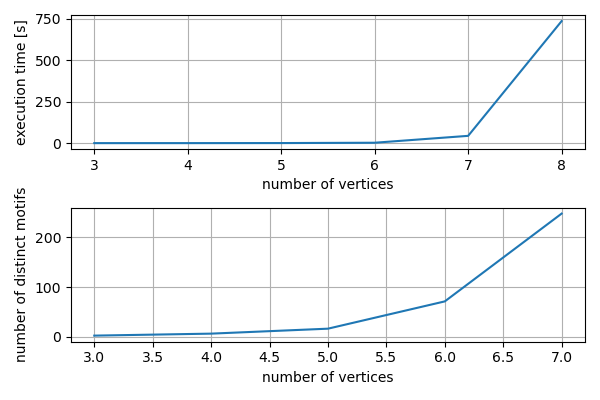

In [58]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (6, 4))
ax.plot([3,4,5,6,7,8], [1/25, 1/10, 1/2.5, 2.36, 43.9, 736])
ax.set(ylabel="execution time [s]", xlabel="number of vertices")
ax.grid()
ax1.plot([3,4,5,6,7], [len(motif_results[i]) for i in range(3, 8)])
ax1.set(ylabel="number of distinct motifs", xlabel="number of vertices")
ax1.grid()
plt.tight_layout()
plt.savefig(f'{res_path}/execution_time.png', bbox_inches='tight', dpi = 300)
plt.show()

In [38]:
for n_vertices in range(3, 8):
    print(f"Number of distinct motifs with {n_vertices} vertices: {len(motif_results[n_vertices])}")
    for i, motif in enumerate(list(motif_results[n_vertices].values())):
        gt.graph_draw(motif, output=f'{res_path}/graph/motif/search/motif_{n_vertices}_{i}.png', vertex_size=10, vertex_pen_width=0.5, edge_pen_width=0.5, bg_color=[1,1,1,1])
        motif.save(f"{res_path}/graph/motif/search/files/motif_{n_vertices}_{i}.graphml")

Number of distinct motifs with 3 vertices: 2
Number of distinct motifs with 4 vertices: 6
Number of distinct motifs with 5 vertices: 16
Number of distinct motifs with 6 vertices: 71
Number of distinct motifs with 7 vertices: 248


In [ ]:
# directory/folder path
dir_path = f"{res_path}/graph/motif/search/files/"

# list to store files
res = []

# Iterate directorya = []
for file_path in os.listdir(dir_path):
    # check if current file_path is a file
    if os.path.isfile(os.path.join(dir_path, file_path)) and file_path.endswith(".graphml"):
        res.append(gt.load_graph(dir_path + file_path))

In [ ]:
dict = {}
c = 0
for graph_found in res:
    check = False
    for distinct_graph in list(dict.values()):
        checkTMP = gt.isomorphism(graph_found, distinct_graph)
        if checkTMP:
            check = checkTMP
            break
    if check:
        continue
    else:
        c += 1
        dict[c] = graph_directory

In [ ]:
dict

In [ ]:
if 0:
    # CHOOSE MOTIFS TO SEARCH FOR BY HAND
    if 1:
        for frame in np.random.choice(frames, 10):
            X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
            g, pos = gt.geometric_graph(X, cutoff_distance[frame])
            gt.graph_draw(g, pos=pos, output=f'{res_path}/graph/motif/search/graph_{frame}.png', vertex_size=10, vertex_pen_width=0.5, edge_pen_width=0.5, )

            for n_vertices in range(3, 10):
                motifs, counts = gt.motifs(g, n_vertices)
                # print(motifs)
                for i in range(len(motifs)):
                    gt.graph_draw(motifs[i], output=f'{res_path}/graph/motif/search/motif_{frame}_{n_vertices}_{i}.png', vertex_size=10, vertex_pen_width=0.5, edge_pen_width=0.5)
        
    if 0:
        # build by hand the motif list array:
        motifList = []
        # example
        motifList.append(motif[1])

        # write the sizes of the motifs in the sizeList array
        sizeList = []
        # save the motifList 
        for i, motif in enumerate(motifList):
            gt.graph_draw(motif, output=f'{res_path}/graph/motif_{i}.pdf', vertex_size=10)
            motif.save(f'{res_path}/graph/motif_{i}.graphml')
else:
    sizeList = [3, 4, 5, 5]
    motifList = []
    for i in range(len(sizeList)):
        motifList.append(gt.load_graph(f'{res_path}/graph/motif/selected/motif_{i}.graphml'))

In [ ]:
frame = 40000
X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
dicts = {}
for i in range(len(X)):
    dicts[i] = (X[i, 0], X[i, 1])
# generate random geometric graph with cutoff distance 2.2 times the mean diameter the droplets have at that frame
G = nx.random_geometric_graph(len(dicts), cutoff_distance[frame], pos=dicts, dim=2)
node_pos = nx.get_node_attributes(G, 'pos')
g, pos = gt.geometric_graph(X, cutoff_distance[frame])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw(G, pos=node_pos, node_size=10, node_color=colors, with_labels=True, ax=ax)
ax.set(xlim=(xmin, xmax), ylim=(ymax, ymin), title = f"frame {frame} --> {motif_search(motifList, sizeList, g)}", xlabel="x [px]", ylabel="y [px]")
plt.show()

In [ ]:
motif_array = np.zeros((len(frames), len(motifList)+1), dtype=int)
for frame in tqdm(frames):
    X = np.array(trajectories.loc[trajectories.frame == frame, ['x', 'y']])
    g, pos = gt.geometric_graph(X, cutoff_distance[frame])
    motif_array[frame] = np.concatenate(([frame], list(motif_search(motifList, sizeList, g))))
motif_df = pd.DataFrame(motif_array, columns=["frame"] + [f"motif_{i}" for i in range(len(motifList))])
motif_df.to_parquet(f"{analysis_data_path}/graph/motifs_factor{factor}.parquet")

In [ ]:
motif_array = pd.read_parquet(f"{analysis_data_path}/graph/motifs_factor{factor}.parquet")
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(8, 6))
ax.plot(frames/fps, motif_array.motif_0)
ax1.plot(frames/fps, motif_array.motif_1)
ax2.plot(frames/fps, motif_array.motif_2)
ax3.plot(frames/fps, motif_array.motif_3)
ax.set(title = f"Motif counts - factor {factor} - {system_name}", ylabel = "Triangle")
ax1.set(ylabel = "Square")
ax2.set(ylabel = "Pentagon")
ax3.set(xlabel = "Time [s]", ylabel="Home")
plt.tight_layout()
if save_verb:
    plt.savefig(f"{res_path}/graph/motif/motif_counts_factor{factor}.png", bbox_inches='tight')
    plt.savefig(f"{pdf_res_path}/graph/motif_counts_factor{factor}.pdf", bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()